# Main processing of multiplane data with existing PSF 

In [1]:
# general imports 
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import pickle
from tkinter import filedialog
from tkinter import *
import json
from tqdm import tqdm
import csv
from natsort import natsorted
from xml.etree import ElementTree
import storm_analysis.sa_library.sa_h5py as saH5Py


In [2]:

def load_multiplane_calibration(filename):
    if not os.path.exists(filename):
        # ask for user input for calibraiton
        root = Tk()
        root.withdraw()
        filepath = filedialog.askopenfile(title='Select calibration data file', filetypes =[('Calibration file', '*.json')])
        fopen = filepath.name
    else:
        fopen = os.path.join(filename)
    f = open(fopen)
    cal = json.load(f, object_hook=jsonKeys2int) 
    return cal


def jsonKeys2int(x):
    if isinstance(x, dict):
        return {(int(k) if k.isnumeric() else k):v for k,v in x.items()}
    return x


def txt2csv(txtname):
    csvname = txtname.replace(".txt", ".csv")
    with open(txtname, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(",") for line in stripped if line)
        with open(csvname, 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerows(lines)

    print(f"Finished writing {csvname}")

    

def hdf5PxlToTxtNm(hdf5_name, txt_name, pixel_size):
    locfields = ['x', 'y', 'z']
    nmfields = [f + "nm" for f in locfields]
    scale_map = {'x': pixel_size, 'y': pixel_size, 'z': 1000.0}

    with saH5Py.SAH5Reader(hdf5_name) as h5:
        # nm_per_pixel = h5.getPixelSize()  
        _ = h5.getMovieInformation()

        def _fmt(val, is_int):
            return str(val) if is_int else f"{val:.3f}"

        with open(txt_name, "w") as fp:
            has_header = False
            fields = None

            # Convert tracks.
            if h5.hasTracks():
                index = 0
                print("Converting tracks.")
                for tracks in tqdm(h5.tracksIterator()):
                    if not has_header:
                        fields = sorted(tracks.keys())
                        fp.write(",".join(["index"] + fields + nmfields) + "\n")
                        has_header = True

                    for i in range(tracks["x"].size):
                        row = [str(index)]
                        # original fields
                        for field in fields:
                            is_int = (tracks[field].dtype == np.int32)
                            row.append(_fmt(tracks[field][i], is_int))
                        # nm fields in x,y,z order with requested scaling
                        for f in locfields:
                            is_int = (tracks[f].dtype == np.int32)
                            row.append(_fmt(tracks[f][i] * scale_map[f], is_int=False))
                        fp.write(",".join(row) + "\n")
                        index += 1

            # Convert localizations.
            else:
                index = 0
                print("Converting localizations.")
                for fnum, locs in tqdm(h5.localizationsIterator(drift_corrected=False)):
                    if not has_header:
                        fields = sorted(locs.keys())
                        fp.write(",".join(["index", "frame"] + fields + nmfields) + "\n")
                        has_header = True

                    for i in range(locs["x"].size):
                        row = [str(index), str(fnum)]
                        # original fields
                        for field in fields:
                            is_int = (locs[field].dtype == np.int32)
                            row.append(_fmt(locs[field][i], is_int))
                        # nm fields in x,y,z order with requested scaling
                        for f in locfields:
                            is_int = (locs[f].dtype == np.int32)
                            row.append(_fmt(locs[f][i] * scale_map[f], is_int=False))
                        fp.write(",".join(row) + "\n")
                        index += 1



def get_PSF_root():
    """
    Get the root directory for PSF files.
    """
    root = Tk()
    root.withdraw()
    psf_root = filedialog.askdirectory(title='Select PSF root directory')
    if not psf_root:
        raise ValueError("No PSF root directory selected.")
    print(f"Using PSF root directory: {psf_root}")
    return psf_root


def get_data_root():
    """
    Get the root directory for data files.
    """
    root = Tk()
    root.withdraw()
    data_root = filedialog.askdirectory(title='Select data root directory')
    if not data_root:
        raise ValueError("No data root directory selected.")
    print(f"Using data root directory: {data_root}")
    return data_root

def copy_files_to_data(psf_root, data_root, file_specs=['']):
    
    # spline files 
    spline_files = [f for f in os.listdir(psf_root) if f.endswith('.spline')]
    for psf in spline_files:
        src = os.path.join(psf_root, psf)
        dst = os.path.join(data_root, psf)
        copy_file(src, dst)
    

    #calibration_files & weights file
    calib_files = [f for f in os.listdir(psf_root) if f.endswith('.npy')]
    for c in calib_files:
        src = os.path.join(psf_root, c)
        dst = os.path.join(data_root, c)
        copy_file(src, dst)


    # map files 
    map_file = [f for f in os.listdir(psf_root) if f.endswith('.map') and "merge" in f]
    for m in map_file:
        src = os.path.join(psf_root, m)
        dst = os.path.join(data_root, m)
        copy_file(src, dst)

    # input data 
    for f in file_specs:
        src = os.path.join(psf_root, f)
        dst = os.path.join(data_root, f)
        copy_file(src, dst)

    xmls = [x for x in os.listdir(psf_root) if x.endswith('.xml') and "multip" in x]
    for x in xmls:
        src = os.path.join(psf_root, x)
        dst = os.path.join(data_root, x)
        copy_file(src, dst)

    print("Finished copying files.")
    return list(spline_files), list(calib_files), list(map_file),  list(xmls), file_specs



def copy_file(src, dst):
    if os.path.exists(src):
        if not os.path.exists(dst):
            import shutil
            shutil.copy(src, dst)
            print(f"Copied {os.path.basename(src)} to {dst}.")
        else:
            print(f"{os.path.basename(src)} already exists at {dst}.")
    else:
        print(f"Source file {src} does not exist.")


In [3]:
psf_root = get_PSF_root()
data_root = get_data_root()
#root = r'D:\moritz\Technical_paper\202508_smlm_test\CS4_e642nm_kinetix2_dz25_3\cal_data' # r'D:\moritz\Technical_paper\4x2\smlm_tilt_corrected_200nmbeads_test_v2\babcock_data_v2' #
os.chdir(data_root)
print(os.getcwd())

script_root = r'E:\GitHub\storm-analysis\storm_analysis'

filepath_mcal = os.path.join(psf_root, 'cal.json')
mcal = load_multiplane_calibration(filepath_mcal)


# processing parameters
global ref_plane, exp_time, pixel_size, camera_gain, camera_offset, iterations, dz, focus_plane, threshold
ref_plane = 0 # python indexing
exp_time = 100
pixel_size = 108
camera_gain = 5
camera_offset = 100
iterations = 1000
model = '2dfixed'
dz = int(mcal['dz_stage'])
threshold = 70
focus_plane = int(mcal['psf_slices']/2)
spline_z_range = int(0.4*mcal['steps'])*int(mcal['dz_stage'])/1000

Using PSF root directory: D:/moritz/Technical_paper/4x2/20250825_beads_splitting_eff/PS4c_e561nm_dz50nm_4x2Scopt_1/cal_data
Using data root directory: D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg
D:\moritz\Technical_paper\4x2\20250902_PAINT\RH28_p3_cy3_cos7_tub_e561nm_f100k_1\reg


## copy files from PSF to data folder 

In [4]:
psf_names_spline, _, _, _, _ = copy_files_to_data(psf_root, data_root)

ch1_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch1_psf.spline.
ch2_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch2_psf.spline.
ch3_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch3_psf.spline.
ch4_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch4_psf.spline.
ch5_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch5_psf.spline.
ch6_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch6_psf.spline.
ch7_psf.spline already exists at D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\ch7_psf.spline.
ch8_psf.spline already exists at D:/moritz/Technical_paper/4x2

In [5]:
# first create final analysis file
import storm_analysis.sa_library.parameters as parameters

def multiplaneXML(spline_names, spline_z_range, z_value, params_name):
    """
    Create a Multiplane parameters object.
    """
    params = parameters.ParametersMultiplaneArb()

    params.setAttr("max_frame", "int", -1)    
    params.setAttr("start_frame", "int", -1)

    #params.setAttr("verbosity", "int", 100) # interval of frames displayed during fitting
    params.setAttr("verbosity", "int", 10) # interval of frames displayed during fitting

    params.setAttr("background_sigma", "float", 8.0)
    #params.setAttr("foreground_sigma", "float", 3.0)
    params.setAttr("find_max_radius", "int", 10)
    params.setAttr("independent_heights", "int", 0) # 1: multicolor spectral demixing, 0: single color
    params.setAttr("iterations", "int", 10) # 20 for regular fitting, 1 for beads to avoid spurious splitting
    params.setAttr("mapping", "filename", "merged_map.map")
    params.setAttr("no_fitting", "int", 0)
    #params.setAttr("roi_size", "int", 35)
    params.setAttr("pixel_size", "float", pixel_size)
    # Convert from FWHM in nanometers to sigma in pixels.
    params.changeAttr("sigma", 380/(100.0 * 2.355))
    #params.setAttr("sigma", "float", 2) # 1.5
    params.setAttr("threshold", "float",8.0) 
    params.setAttr("weights", "filename", "weights.npy")
    params.setAttr("z_value", "float-array", z_value)

    # try from https://storm-analysis.readthedocs.io/_/downloads/en/latest/pdf/ / model parameter
    #params.setAttr("model", "string", "3d") # “2dfixed”, “2d”, “3d”, or “Z”

    for i, f in enumerate(spline_names):
        params.setAttr(f"spline{i}", "filename", f)
        #params.setAttr(f"psf{i}", "filename", f)
        
        #params.setAttr(f"channel{i}_cal", "filename", f"calib_{i}.npy")
        params.setAttr(f"channel{i}_cal", "filename", f"calib_dummy_{i}.npy")

        params.setAttr(f"channel{i}_ext", "string", f"pl{i}.tif") # fileextension to define plane
        #params.setAttr(f"channel{i}_ext", "string", f"ch{i}.tif") # fileextension to define plane

        params.setAttr(f"channel{i}_offset", "int", 0)

    # Don't do tracking.
    params.setAttr("descriptor", "string", "1")
    params.setAttr("radius", "float", "0.0")

    params.setAttr("max_z", "float", str(1.2*spline_z_range + 0.001))
    params.setAttr("min_z", "float", str(-(1.2*spline_z_range - 0.001)))

    # Don't do drift-correction.
    params.setAttr("d_scale", "int", 2)
    params.setAttr("drift_correction", "int", 0)
    params.setAttr("frame_step", "int", 500)
    params.setAttr("z_correction", "int", 0)

    # procedural
    #params.setAttr("convert_to ", "string", ".txt")
    #params.setAttr("fftw_estimate  ", "int", 1)
    # assuming EMCCD instead of custom sCMOS calibration
    #params.setAttr("camera_gain", "float", 0.23)
    #params.setAttr("camera_offset", "float", 100.0)

    params.toXMLFile(params_name)



print(f"Using stage based offsets: {(0.5*mcal['steps'] - np.array(mcal['fp'])) * mcal['dz_stage']/1000}")
z_value =  [(0.5*mcal['steps'] - mcal['fp'][ix]) * mcal['dz_stage']/1000 for ix in range(len(mcal['fp']))]


multiplane_params = 'validation_multiplane.xml'
multiplaneXML(psf_names_spline, np.abs(spline_z_range), z_value, multiplane_params)
#multiplaneXML(psf_names_normed, np.abs(spline_z_range), z_value, multiplane_params)  # with psf stacks instead of spline, need to change params.setAttr(f"spline{i}", "filename", f) to psf{i}


Using stage based offsets: [ 2.075  1.325  0.575 -0.175 -0.575 -1.525 -2.275 -2.975]


Calculating Cramer-Rao bounds.
z -3920.0
z -3507.4
z -3094.7
z -2682.1
z -2269.5
z -1856.8
z -1444.2
z -1031.6
z -618.9
z -206.3
z 206.3
z 618.9
z 1031.6
z 1444.2
z 1856.8
z 2269.5
z 2682.1
z 3094.7
z 3507.4
z 3920.0
Correcting for mapping.


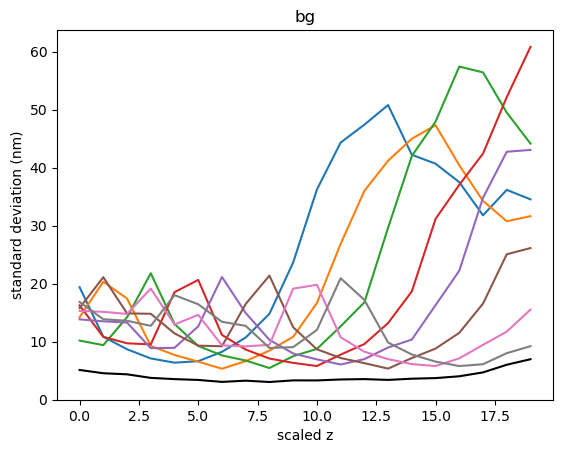

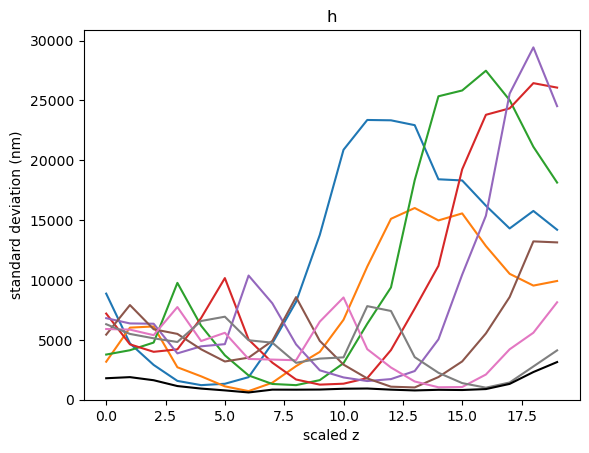

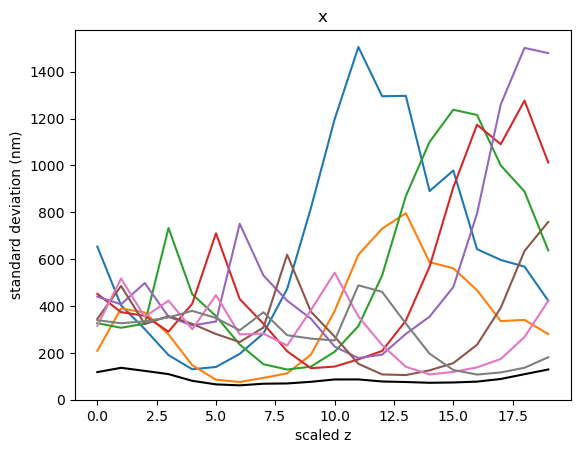

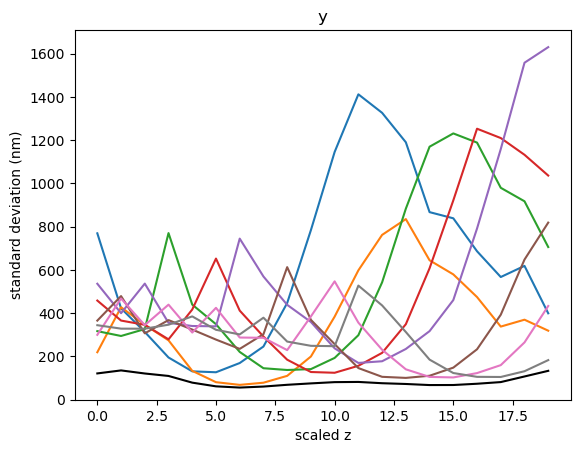

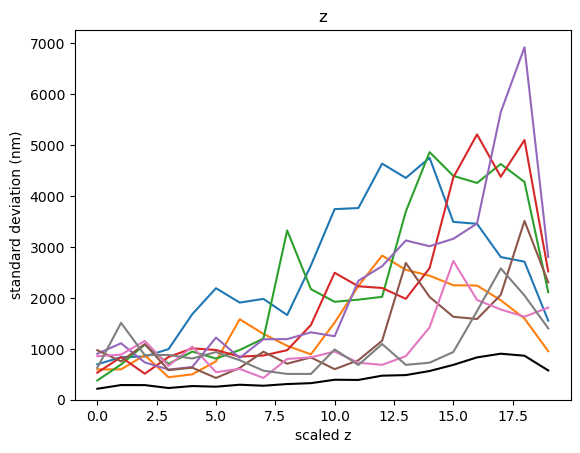

In [6]:
import storm_analysis.multi_plane.plane_weighting as planeWeighting
'''
def runPlaneWeighting(xml, output, background, photons, no_plots = False):
    xml - The analysis XML file.
    output - File name to save the weights in.
    background - Per pixel background in e- for each plane (as a list).
    photons - Integrated peak intensity in e-.
    no_plots - Don't show any plots.
'''
background = [7500 for _ in psf_names_spline]
#background = [200 for _ in psf_names_spline]

planeWeighting.runPlaneWeighting(multiplane_params, 
                                 "weights.npy",
                                 background,   # 20 photons average background in each plane
                                 20000,       # 2000 photon average PSF sum.
                                 no_plots = False)


# Run the analysis

In [7]:
# parse the raw_data filelist
#filekey = r'A1_vim680_silicone_demag2_3_MMStack_Pos0_f(\d+)_'
filekey = r'RH28_p3_cy3_cos7_tub_e561nm_f100k_1_mm_Pos0_f(\d+)_'
#filekey = r'PS4c_e561nm_4x2Scopt_dt10ms_1_mm_Pos0_f(\d+)_'


indices = [re.match(filekey, f).group(1) for f in os.listdir(data_root) if re.match(filekey, f)]
indices = natsorted(np.unique(indices))
print(f"Unique file indices: {indices}")

Unique file indices: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']


In [8]:
indices = [str(i) for i in range(1, 81)]
print(f"Unique file indices: {indices}")

Unique file indices: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80']


In [ ]:
# batch run all subfiles
import storm_analysis.multi_plane.multi_plane as mp
import storm_analysis.sa_utilities.hdf5_to_txt as txt_conv
import storm_analysis.sa_utilities.hdf5_to_image as img_conv

t = tqdm(total=len(indices), desc="Filename")
subfolder = data_root # r"data"
results_folder = os.path.join(data_root, "results")
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

for index in indices:
    basename = filekey.replace(r"(\d+)", index)
    basename_folder = os.path.join(subfolder, basename)
    #mlist_name = f"multiplane_locfit_{index}.hdf5"
    mlist_name = os.path.join(results_folder, f"multiplane_locfit_{index}.hdf5")
    #list_name = os.path.join(results_folder, f"multiplane_psf_fit_{index}.hdf5")

    print(f"Processing {basename_folder} to file {mlist_name}")

    mp.analyze(basename_folder, mlist_name, multiplane_params)

    # write loc files to txt
    txtname = mlist_name.replace('.hdf5', '.txt')
    txt_conv.hdf5ToTxt(mlist_name, txtname)

    # convert localisation coordinates from pixel to nm
    txtname = mlist_name.replace('.hdf5', '_pxl2nm.txt')
    print(f"Writing to {txtname}")
    hdf5PxlToTxtNm(mlist_name, txtname, pixel_size)

    # convert to csv
    txt2csv(txtname)

    t.update(1)

print(f"Finished processing {data_root}")

Filename:   0%|          | 0/80 [00:00<?, ?it/s]

Processing D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\RH28_p3_cy3_cos7_tub_e561nm_f100k_1_mm_Pos0_f1_ to file D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\results\multiplane_locfit_v1_1.hdf5
weights z scaling - offset: 0.000 scale: 1.000
Found data for 8 planes.
Existing analysis file found. Restarting from last analyzed frame.

version 2023.02.26

Peak finding
Frame: 20 3 14
Frame: 30 5 51
Frame: 40 7 91
Frame: 50 6 149
Frame: 60 15 244
Frame: 70 5 332
Frame: 80 7 397
Frame: 90 7 453
Frame: 100 4 501
Frame: 110 7 554
Frame: 120 4 616
Frame: 130 2 645
Frame: 140 4 678
Frame: 150 7 728
Frame: 160 2 783
Frame: 170 5 827
Frame: 180 5 878
Frame: 190 2 898
Frame: 200 5 948
Frame: 210 3 977
Frame: 220 2 1011
Frame: 230 7 1071
Frame: 240 4 1123
Frame: 250 5 1176
Frame: 260 6 1225
Frame: 270 7 1276
Frame: 280 9 1345
Frame: 290 2 1395
Frame: 300 6 1414
Frame: 310 9 1471
Frame: 320 10 1535
Frame: 330 7 1601
Frame: 

994it [00:12, 77.79it/s]
Filename:   1%|▏         | 1/80 [1:08:06<89:39:58, 4086.05s/it]

Finished writing D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\results\multiplane_locfit_v1_1_pxl2nm.csv
Processing D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\RH28_p3_cy3_cos7_tub_e561nm_f100k_1_mm_Pos0_f2_ to file D:/moritz/Technical_paper/4x2/20250902_PAINT/RH28_p3_cy3_cos7_tub_e561nm_f100k_1/reg\results\multiplane_locfit_v1_2.hdf5
weights z scaling - offset: 0.000 scale: 1.000
Found data for 8 planes.
Existing analysis file found. Restarting from last analyzed frame.


OSError: Unable to open file (bad object header version number)